In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Forestfire classification/

/gdrive/MyDrive/Forestfire classification


In [4]:
ls

fire/  nofire/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [20]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=20
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Forestfire classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1832 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
class_names

['fire', 'nofire']

In [10]:
len(dataset)

30

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[1.20000000e+01 0.00000000e+00 0.00000000e+00]
  [1.58593750e+01 5.78906250e+00 0.00000000e+00]
  [1.12929688e+01 6.00000000e+00 2.82421875e+00]
  ...
  [0.00000000e+00 2.05859375e+00 1.10585938e+01]
  [0.00000000e+00 3.00000000e+00 1.20000000e+01]
  [0.00000000e+00 3.00000000e+00 1.20000000e+01]]

 [[1.39296875e+01 9.64843750e-01 0.00000000e+00]
  [1.03416748e+01 1.16836548e+00 0.00000000e+00]
  [1.87066650e+00 2.67471313e-01 9.92889404e-02]
  ...
  [0.00000000e+00 1.09375000e+00 1.68476562e+01]
  [0.00000000e+00 2.03515625e+00 1.77890625e+01]
  [0.00000000e+00 2.03515625e+00 1.77890625e+01]]

 [[1.30585938e+01 4.76562500e+00 1.88281250e+00]
  [6.47428894e+00 2.04069519e+00 9.74502563e-01]
  [1.30670166e+00 3.65873718e+00 8.03137207e+00]
  ...
  [2.17075043e+01 3.49492188e+01 6.13046875e+01]
  [2.25937500e+01 3.58906250e+01 6.22460938e+01]
  [2.25937500e+01 3.58906250e+01 6.22460938e+01]]

 ...

 [[1.88281250e+00 3.82421875e+00 9.41406250e-01]
  [2.84765

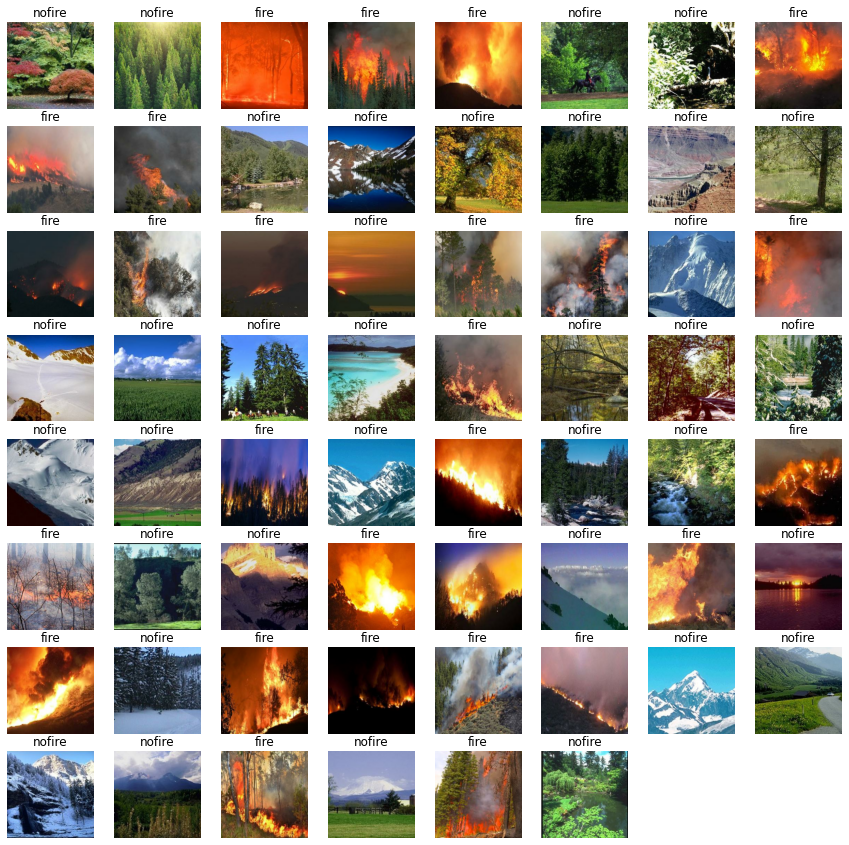

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
24/24 [==============================] - 247s 7s/step - loss: 0.9285 - accuracy: 0.6521 - val_loss: 0.2116 - val_accuracy: 0.9247
Epoch 2/20
24/24 [==============================] - 165s 7s/step - loss: 0.2474 - accuracy: 0.9055 - val_loss: 0.1228 - val_accuracy: 0.9731
Epoch 3/20
24/24 [==============================] - 163s 7s/step - loss: 0.1797 - accuracy: 0.9315 - val_loss: 0.1810 - val_accuracy: 0.9301
Epoch 4/20
24/24 [==============================] - 162s 7s/step - loss: 0.1933 - accuracy: 0.9295 - val_loss: 0.1406 - val_accuracy: 0.9409
Epoch 5/20
24/24 [==============================] - 165s 7s/step - loss: 0.1499 - accuracy: 0.9397 - val_loss: 0.1171 - val_accuracy: 0.9570
Epoch 6/20
24/24 [==============================] - 162s 7s/step - loss: 0.1175 - accuracy: 0.9582 - val_loss: 0.0851 - val_accuracy: 0.9731
Epoch 7/20
24/24 [==============================] - 161s 7s/step - loss: 0.1150 - accuracy: 0.9589 - val_loss: 0.1037 - val_accuracy: 0.9624
Epoch 8/20
24

In [22]:
model.evaluate(test_ds)

3/3 [==============================] - 15s 2s/step - loss: 0.0443 - accuracy: 0.9810


[0.044306252151727676, 0.9810126423835754]

In [23]:
acc = history.history['accuracy']
loss = history.history['loss']

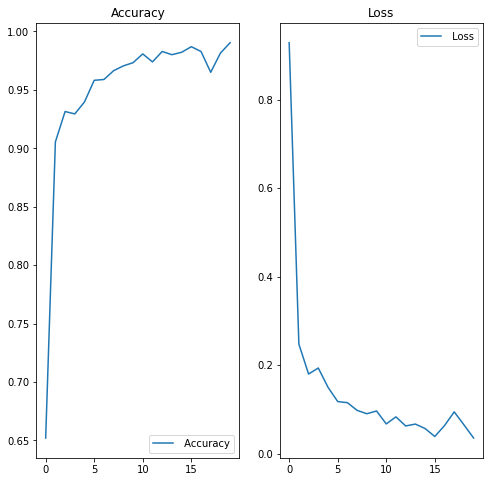

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

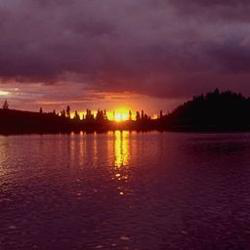

In [26]:
image_path = "/gdrive/MyDrive/Forestfire classification/nofire/abc192.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [27]:
pred = model.predict(scaled_img)

In [28]:
output = class_names[np.argmax(pred)]

In [29]:
output

'fire'

In [30]:
model.save("Forestfire classification.h5")